## Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/AssignmentUpgrad/CNN_assignment.zip" > /dev/null

Import the necessary libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Reading/Data Understanding → Defining the path for train and test images

The data has been downloaded and organized into an 'images' folder, which is further divided into 'train' and 'test' subfolders.

This assignment involves a dataset of approximately 2339 images depicting various types of skin cancer. Within both the 'train' and 'test' subfolders, there are 9 subdirectories, each containing images corresponding to one of the 9 different skin cancer types.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [ ]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Dataset Creation
To Do: Create train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180.

- **Load using keras.preprocessing**
Let's load these images off disk using the helpful image_dataset_from_directory utility.

- Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualize the data
Todo, create a code to visualize one instance of all the nine classes present in the dataset

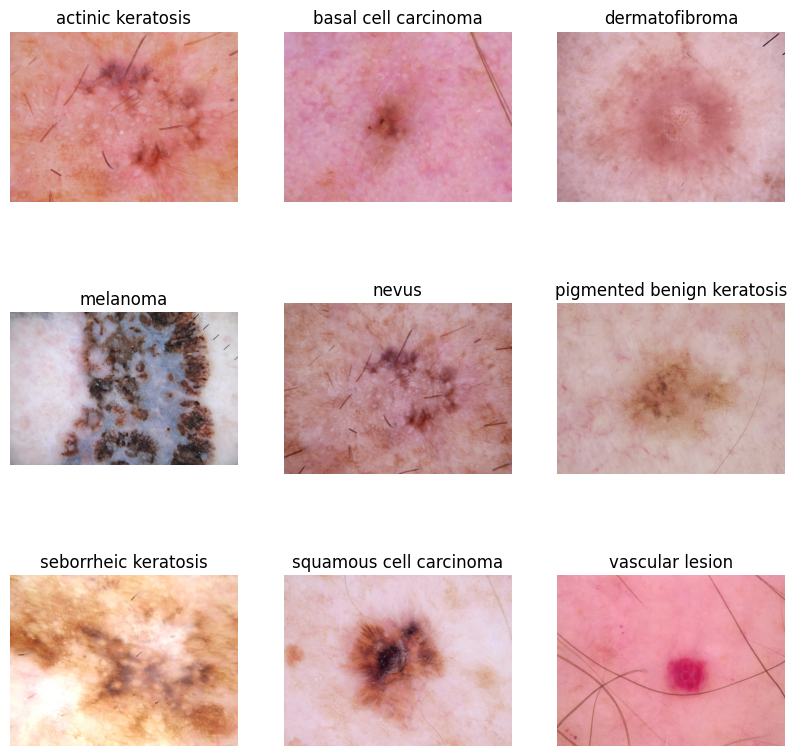

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

The image_batch is a tensor with dimensions (32, 180, 180, 3), representing a batch of 32 images, each with a size of 180x180 pixels and 3 color channels (RGB). The label_batch is a tensor with dimensions (32,), containing the corresponding labels for the 32 images.

Using Dataset.cache(), the images are stored in memory after being loaded from disk during the first epoch. Meanwhile, Dataset.prefetch() allows data preprocessing and model execution to occur simultaneously during training.

In [ ]:
# Optimize the data pipeline for training and validation datasets
# AUTOTUNE automatically tunes the performance based on system resources
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Configure the training dataset
train_ds = train_ds.cache()  # Cache the dataset in memory after the first epoch
train_ds = train_ds.shuffle(1000)  # Shuffle the dataset with a buffer size of 1000 for randomness
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)  # Prefetch data to overlap preprocessing and model execution

# Configure the validation dataset
val_ds = val_ds.cache()  # Cache the dataset in memory after the first epoch
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)  # Prefetch data to optimize validation process


## Model Building & training

ToDo:Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).

To normalize pixel values between 0 and 1, use layers.experimental.preprocessing.Rescaling. The RGB channel values, which range from 0 to 255, are not optimal for a neural network. Standardizing these values to fall within the 0 to 1 range is beneficial.

In [ ]:
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11,11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Compile the model
To Do: Choose an appropriate optimiser and loss function for model training

In [ ]:
### choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 16)          │          50,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 5, 5, 128)           │         247,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 720,601 (2.75 MB)

 Trainable params: 720,601 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model for ~20 epochs

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 127ms/step - accuracy: 0.1738 - loss: 2.0918 - val_accuracy: 0.1499 - val_loss: 2.0671 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.2026 - loss: 2.0181 - val_accuracy: 0.2394 - val_loss: 2.0226 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2544 - loss: 1.9603 - val_accuracy: 0.2506 - val_loss: 1.9385 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.2833 - loss: 1.8652 - val_accuracy: 0.2796 - val_loss: 1.8024 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3413 - loss: 1.7474 - val_accuracy: 0.3714 - val_loss: 1.7075 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3611 - loss: 1.6866 - val_accuracy: 0.3714 - val_loss: 1.6497 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3864 - loss: 1.6387 - val_a

Visualizing training results

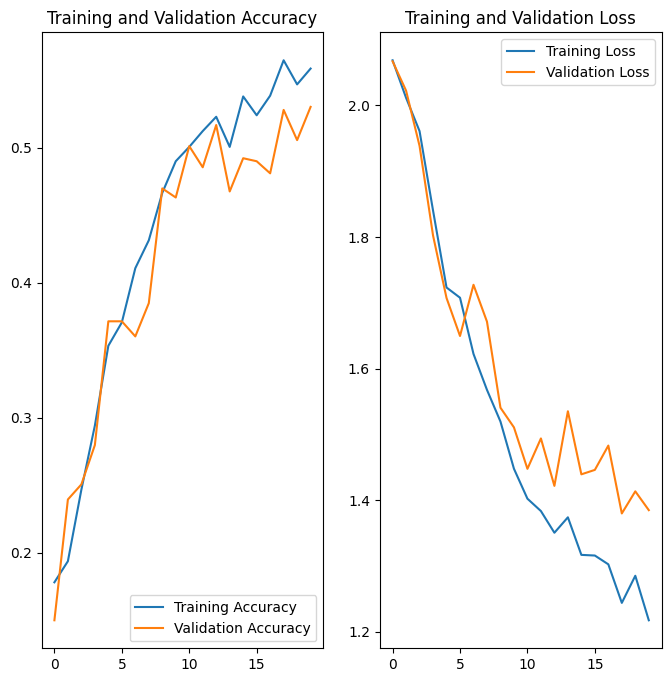

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings

- The training accuracy and validation accuracy are nearly identical, but both are quite low, suggesting that the model is underfitting.

 - While the training loss is minimal, the validation loss shows significant fluctuations. This indicates that the model's performance is suboptimal.





## Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting

## Creating a data augmentation pipeline using TensorFlow's tf.keras.Sequential API.

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal_and_vertical",
                               input_shape=(img_height,
                                            img_width,
                                            3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.1)
  ]
)


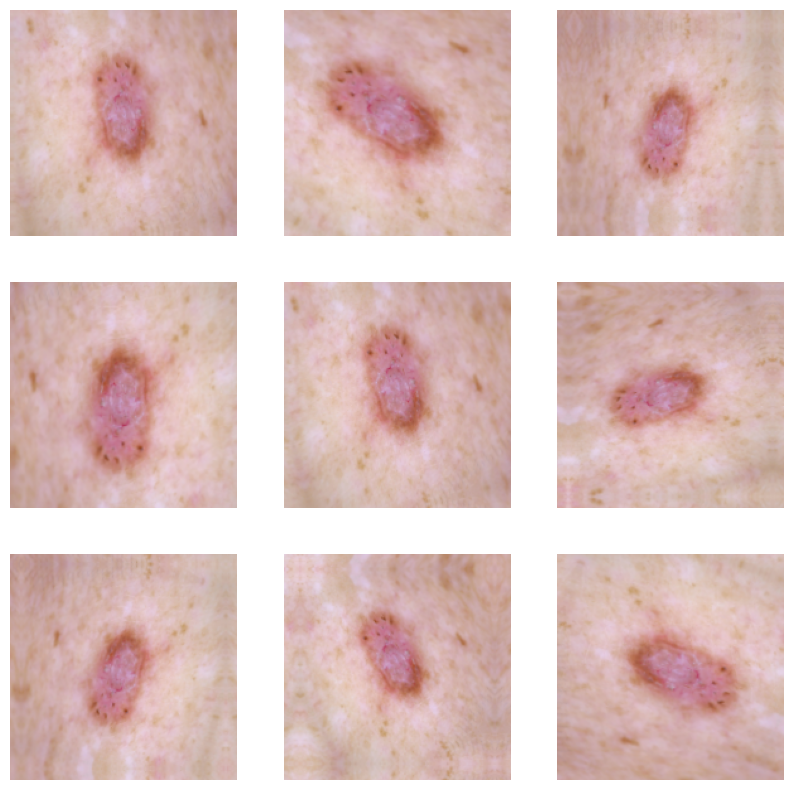

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Create the model

In [ ]:
model = Sequential()

model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11, 11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

Compiling the model

In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 45, 45, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 22, 22, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 11, 11, 16)          │          50,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 5, 5, 128)           │         247,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 720,601 (2.75 MB)

 Trainable params: 720,601 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train the model with 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.1785 - loss: 2.1367 - val_accuracy: 0.2058 - val_loss: 2.0703 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.2012 - loss: 2.0375 - val_accuracy: 0.1924 - val_loss: 2.0320 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.2032 - loss: 2.0316 - val_accuracy: 0.1924 - val_loss: 2.0281 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2041 - loss: 2.0403 - val_accuracy: 0.2058 - val_loss: 2.0214 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.2225 - loss: 2.0142 - val_accuracy: 0.1499 - val_loss: 2.0328 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1721 - loss: 2.0229
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.1722 - loss: 2.0229 - val_ac

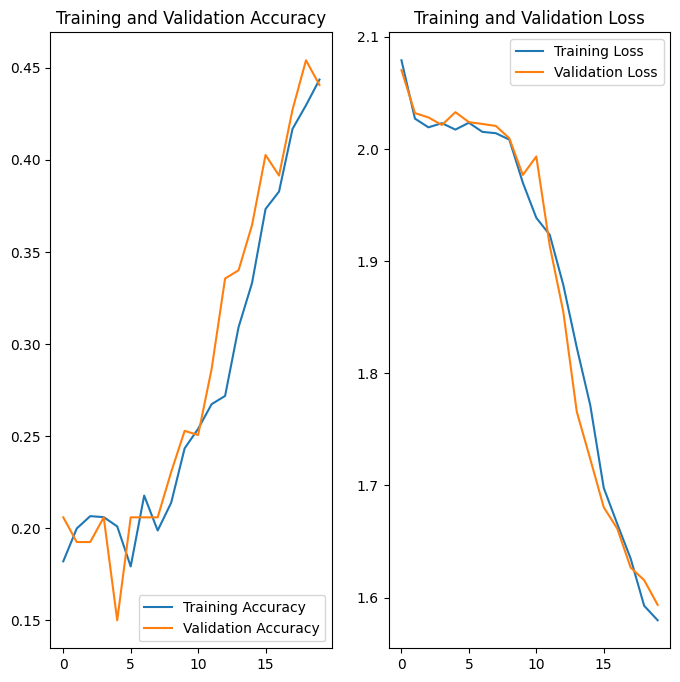

In [ ]:
# Visualizing the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings:

- The Training accuracy and validation accuracy are almost same. This is a sign of good fit but the accuracy is still very low. The model requires more epochs to train with class imbalance handled.

## Class distribution: Examine the current class distribution in the training dataset

In [ ]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,vascular lesion,139
1,melanoma,438
2,dermatofibroma,95
3,seborrheic keratosis,77
4,basal cell carcinoma,376
5,squamous cell carcinoma,181
6,nevus,357
7,actinic keratosis,114
8,pigmented benign keratosis,462


<Axes: xlabel='No. of Image', ylabel='Class'>

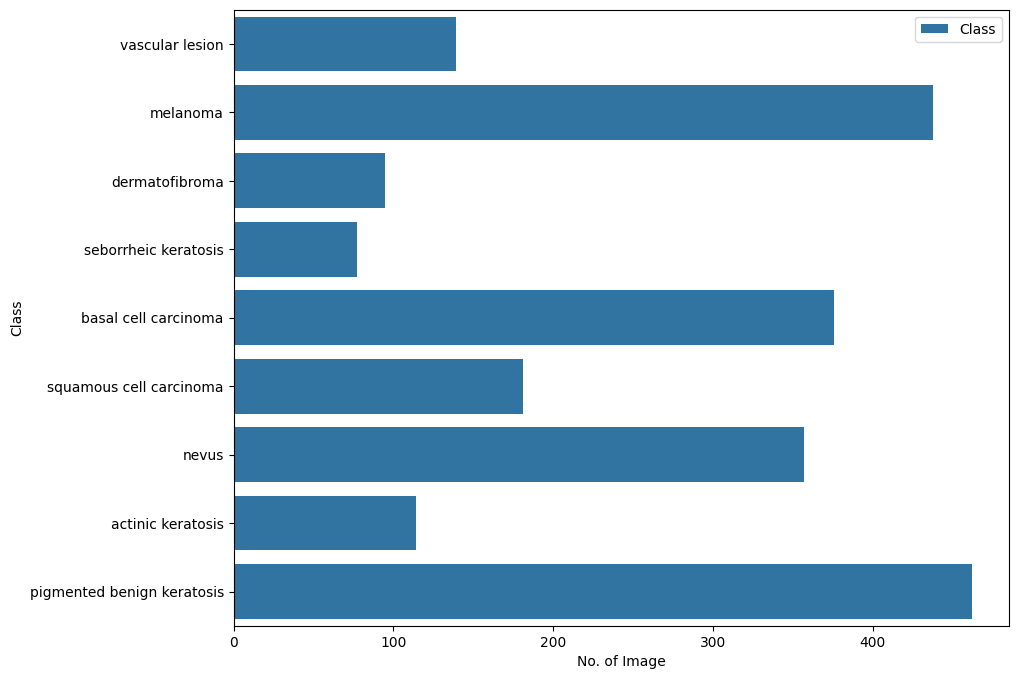

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

**Findings**

- Which class has the least number of samples?
: seborrheic keratosis (77)
- Which classes dominate the data in terms proportionate number of samples?
: pigmented benign keratosis (462)

## Handling class imbalances:
Rectify class imbalances present in the training dataset with Augmentor library.

There is a class imbalance to solve this using a python package Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
#install Augmentor
!pip install Augmentor

In [ ]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A13FC628890>: 100%|██████████| 500/500 [00:15<00:00, 32.97 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A13FC3A9210>: 100%|██████████| 500/500 [00:17<00:00, 28.12 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A13FC38D390>: 100%|██████████| 500/500 [00:17<00:00, 29.21 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7A13FC3F8290>: 100%|██████████| 500/500 [01:20<00:00,  6.22 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A146C1AD350>: 100%|██████████| 500/500 [01:15<00:00,  6.59 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A13FC4A3AD0>: 100%|██████████| 500/500 [00:14<00:00, 35.28 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A142B3158D0>: 100%|██████████| 500/500 [00:32<00:00, 15.29 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A13FC3F5790>: 100%|██████████| 500/500 [00:13<00:00, 36.12 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A140EDA5D50>: 100%|██████████| 500/500 [00:14<00:00, 35.22 Samples/s]


In [ ]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Create a training dataset

In [ ]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Create a validation dataset

In [ ]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## Model Building & training on the rectified class imbalance data :

In [ ]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

 ### Create your model

In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

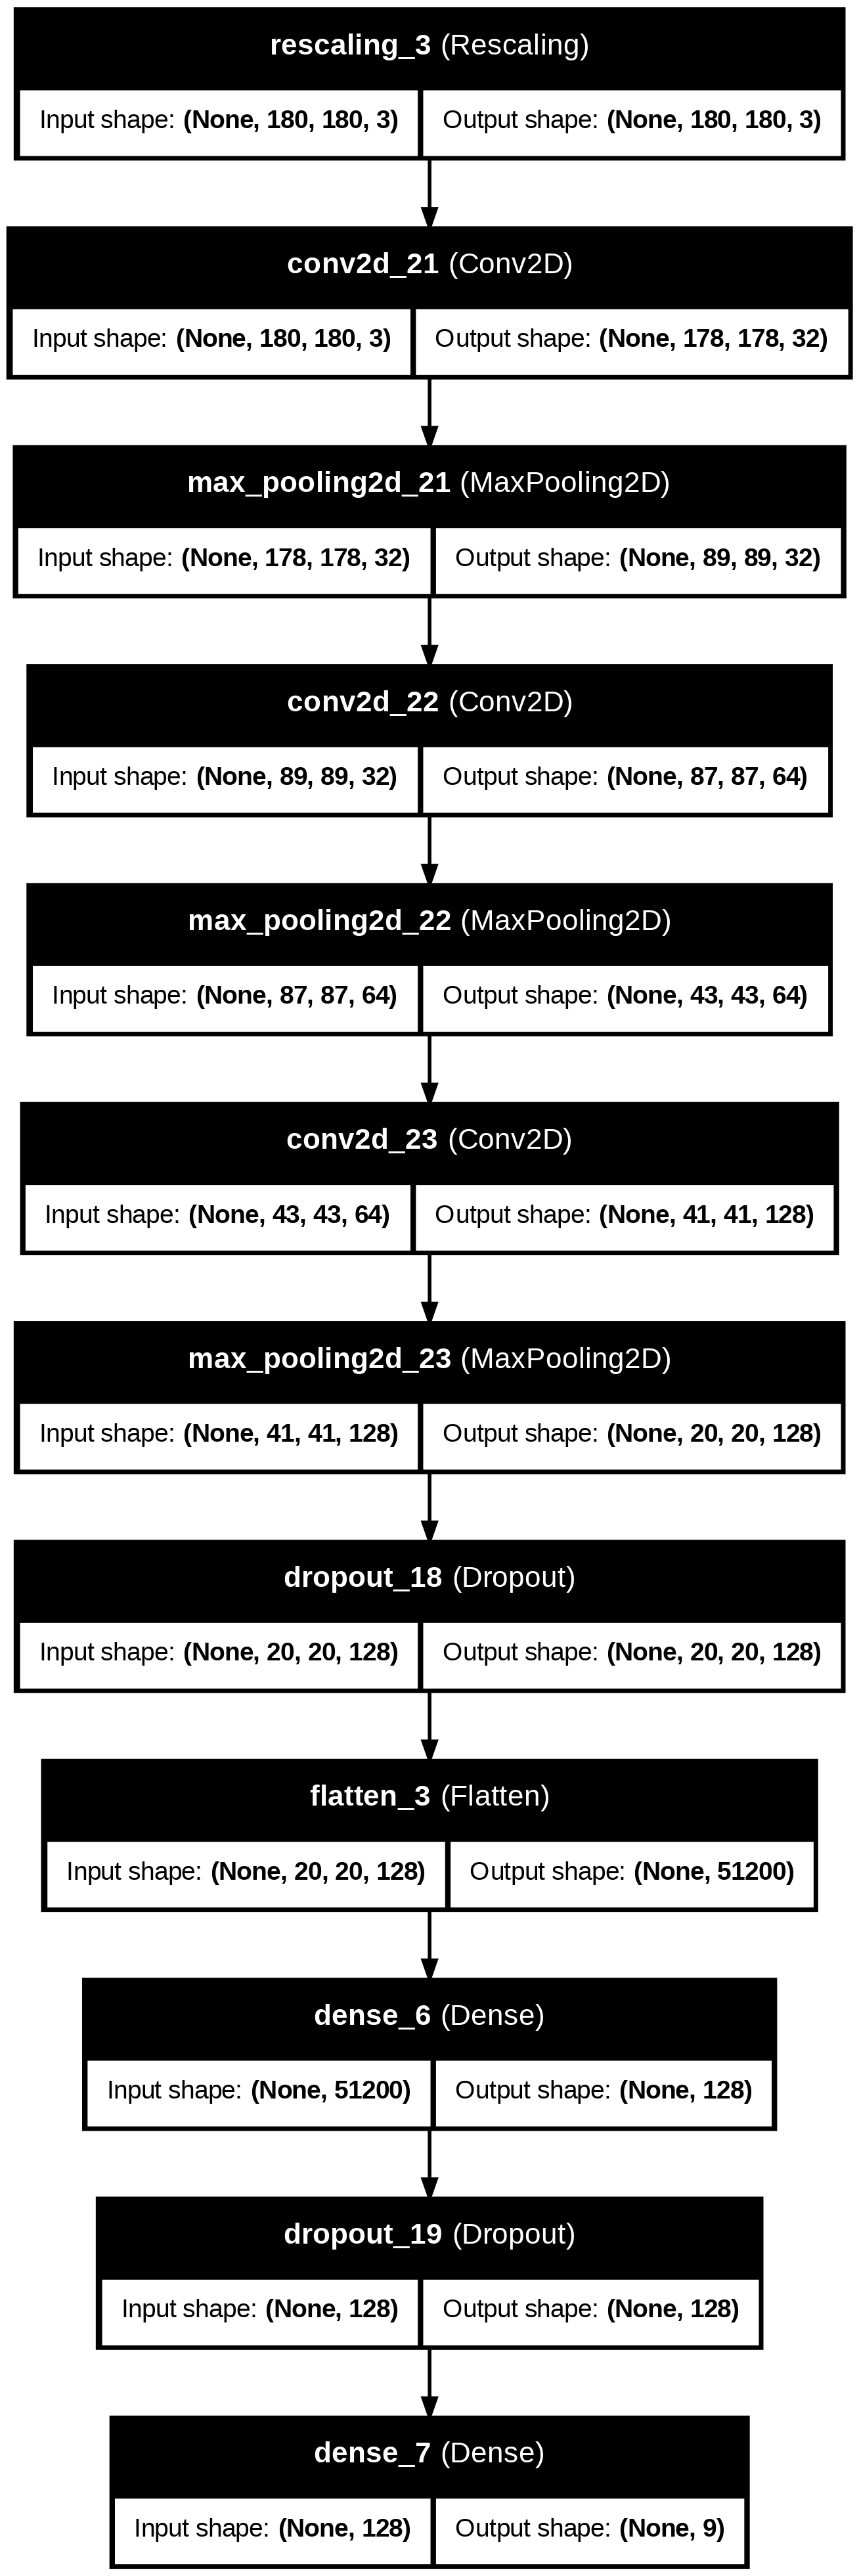

In [ ]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Compile the Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

**Train the model for ~30 epochs**

In [ ]:
# Train the model
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1772 - loss: 2.1235
Epoch 1: val_accuracy improved from -inf to 0.38382, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.1780 - loss: 2.1211 - val_accuracy: 0.3838 - val_loss: 1.6122
Epoch 2/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3837 - loss: 1.6276
Epoch 2: val_accuracy improved from 0.38382 to 0.48849, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.3841 - loss: 1.6266 - val_accuracy: 0.4885 - val_loss: 1.3140
Epoch 3/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4648 - loss: 1.4080
Epoch 3: val_accuracy improved from 0.48849 to 0.53675, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4650 - loss: 1.4078 - val_accuracy: 0.5367 - val_loss: 1.2881
Epoch 4/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5237 - loss: 1.2616
Epoch 4: val_accuracy improved from 0.53675 to 0.60505, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5239 - loss: 1.2611 - val_accuracy: 0.6050 - val_loss: 1.0538
Epoch 5/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5920 - loss: 1.0759
Epoch 5: val_accuracy improved from 0.60505 to 0.62880, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5920 - loss: 1.0760 - val_accuracy: 0.6288 - val_loss: 1.0127
Epoch 6/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6397 - loss: 0.9761
Epoch 6: val_accuracy improved from 0.62880 to 0.67335, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6397 - loss: 0.9762 - val_accuracy: 0.6733 - val_loss: 0.8929
Epoch 7/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6562 - loss: 0.8916
Epoch 7: val_accuracy improved from 0.67335 to 0.68671, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6564 - loss: 0.8911 - val_accuracy: 0.6867 - val_loss: 0.8578
Epoch 8/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7070 - loss: 0.8116
Epoch 8: val_accuracy improved from 0.68671 to 0.72606, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7070 - loss: 0.8113 - val_accuracy: 0.7261 - val_loss: 0.8238
Epoch 9/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7545 - loss: 0.6729
Epoch 9: val_accuracy did not improve from 0.72606
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.7544 - loss: 0.6730 - val_accuracy: 0.6407 - val_loss: 1.0679
Epoch 10/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7761 - loss: 0.6073
Epoch 10: val_accuracy improved from 0.72606 to 0.74016, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7762 - loss: 0.6071 - val_accuracy: 0.7402 - val_loss: 0.7666
Epoch 11/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8062 - loss: 0.5464
Epoch 11: val_accuracy improved from 0.74016 to 0.77431, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8061 - loss: 0.5464 - val_accuracy: 0.7743 - val_loss: 0.7169
Epoch 12/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8229 - loss: 0.4683
Epoch 12: val_accuracy did not improve from 0.77431
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8228 - loss: 0.4685 - val_accuracy: 0.7223 - val_loss: 0.8209
Epoch 13/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8151 - loss: 0.4722
Epoch 13: val_accuracy improved from 0.77431 to 0.80624, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8151 - loss: 0.4722 - val_accuracy: 0.8062 - val_loss: 0.6092
Epoch 14/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8605 - loss: 0.3769
Epoch 14: val_accuracy improved from 0.80624 to 0.81366, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8604 - loss: 0.3772 - val_accuracy: 0.8137 - val_loss: 0.5974
Epoch 15/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8686 - loss: 0.3584
Epoch 15: val_accuracy improved from 0.81366 to 0.81886, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8685 - loss: 0.3583 - val_accuracy: 0.8189 - val_loss: 0.5879
Epoch 16/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8750 - loss: 0.3420
Epoch 16: val_accuracy did not improve from 0.81886
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8749 - loss: 0.3422 - val_accuracy: 0.7921 - val_loss: 0.6814
Epoch 17/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8601 - loss: 0.3799
Epoch 17: val_accuracy improved from 0.81886 to 0.83370, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8602 - loss: 0.3796 - val_accuracy: 0.8337 - val_loss: 0.5739
Epoch 18/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8907 - loss: 0.2847
Epoch 18: val_accuracy did not improve from 0.83370
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8906 - loss: 0.2849 - val_accuracy: 0.8203 - val_loss: 0.5926
Epoch 19/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8799 - loss: 0.3167
Epoch 19: val_accuracy did not improve from 0.83370
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8798 - loss: 0.3169 - val_accuracy: 0.8233 - val_loss: 0.5786
Epoch 20/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8990 - loss: 0.2550
Epoch 20: val_accuracy improved from 0.83370 to 0.83816, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8991 - loss: 0.2551 - val_accuracy: 0.8382 - val_loss: 0.5372
Epoch 21/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9030 - loss: 0.2479
Epoch 21: val_accuracy improved from 0.83816 to 0.84707, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9030 - loss: 0.2479 - val_accuracy: 0.8471 - val_loss: 0.5753
Epoch 22/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9084 - loss: 0.2461
Epoch 22: val_accuracy did not improve from 0.84707
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9083 - loss: 0.2464 - val_accuracy: 0.8434 - val_loss: 0.5492
Epoch 23/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9105 - loss: 0.2276
Epoch 23: val_accuracy did not improve from 0.84707
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9104 - loss: 0.2278 - val_accuracy: 0.8456 - val_loss: 0.5534
Epoch 24/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9172 - loss: 0.2277
Epoch 24: val_accuracy improved from 0.84707 to 0.84855, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9172 - loss: 0.2279 - val_accuracy: 0.8486 - val_loss: 0.5051
Epoch 25/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9122 - loss: 0.2191
Epoch 25: val_accuracy did not improve from 0.84855
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9122 - loss: 0.2192 - val_accuracy: 0.8471 - val_loss: 0.5382
Epoch 26/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9139 - loss: 0.2207
Epoch 26: val_accuracy did not improve from 0.84855
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9138 - loss: 0.2211 - val_accuracy: 0.8010 - val_loss: 0.6087
Epoch 27/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8945 - loss: 0.2655
Epoch 27: val_accuracy did not improve from 0.84855
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8946 - loss: 0.2653 - val_accuracy: 0.8419 - val_loss: 0.5806
Epoch 28/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9208 - loss: 0.2084
Epoch 28: val_accur

In [ ]:

# Save the model
model.save('skin_cancer_model.h5')  # creates a HDF5 file 'my_model.h5'

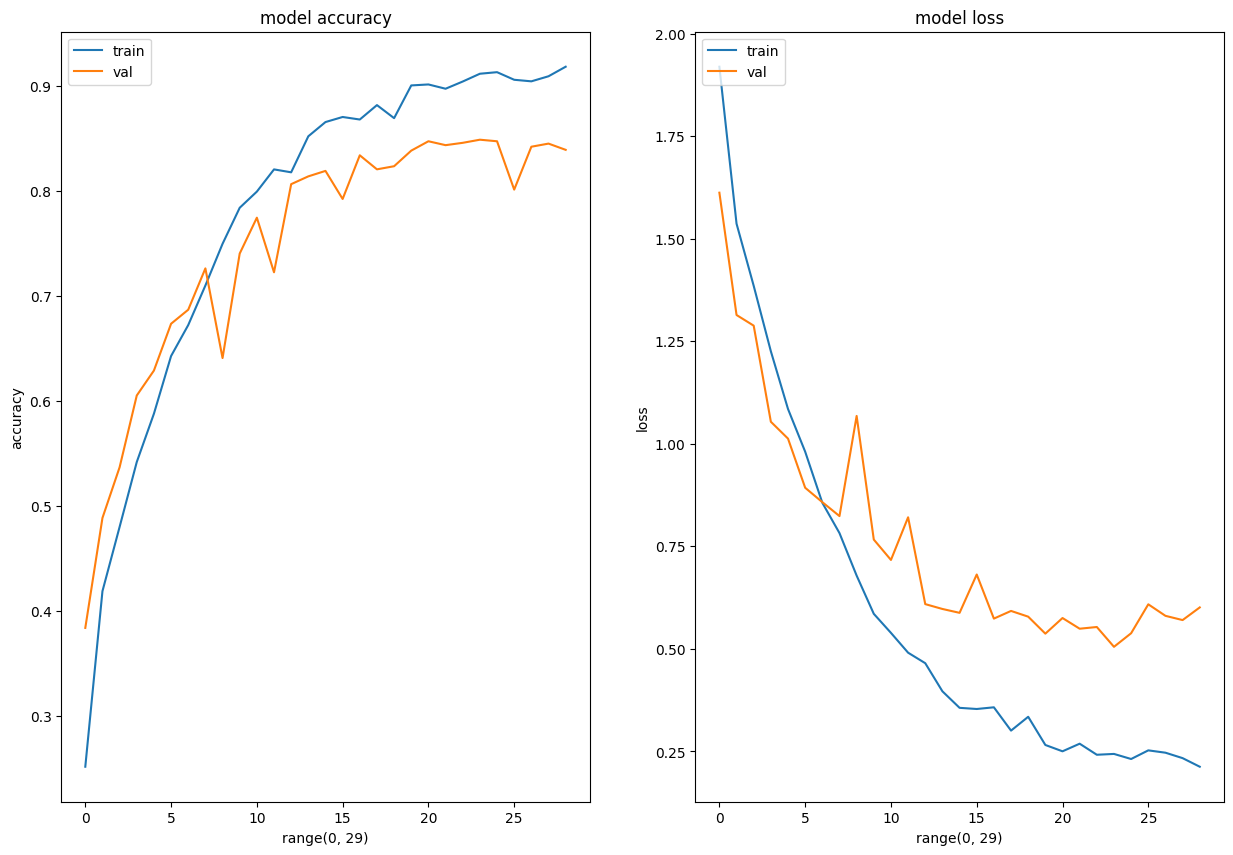

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Findings:**

-The training and validation accuracies are nearly identical, indicating a well-fitted model. Over 30 epochs, the model shows a steady improvement in both training and validation accuracies, reaching around 92% and 84.8% respectively, which suggests that the model is performing well and effectively classifying the images with high accuracy.

## Test the model


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Actual Class: dermatofibroma
Predictive Class: dermatofibroma
The predicted class is correct.


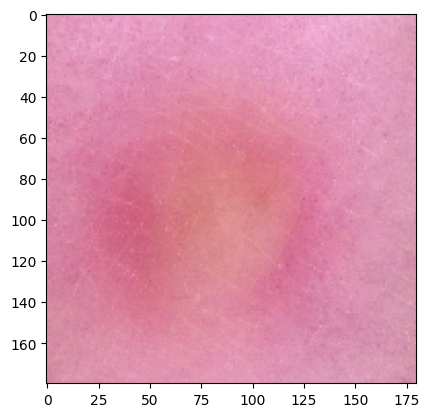

In [ ]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Assuming data_dir_test and class_names are defined elsewhere in the code
# Example:
# data_dir_test = 'path_to_test_data'
# class_names = ['class1', 'class2', 'class3']

# Load a random test image from a random class
random_class = random.choice(class_names)
Test_image_path = os.path.join(data_dir_test, random_class, '*')
Test_image = glob(Test_image_path)
random_image = random.choice(Test_image)
Test_image = load_img(random_image, target_size=(180, 180, 3))
plt.imshow(Test_image)
plt.grid(False)

# Preprocess the image
img = img_to_array(Test_image)
img = np.expand_dims(img, axis=0)

# Predict the class
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]

print(f"Actual Class: {random_class}\nPredictive Class: {pred_class}")

# Check if the predicted class is correct
if pred_class == random_class:
    print("The predicted class is correct.")
else:
    print("The predicted class is incorrect. Please check the model and input data.")
